In [ ]:
import numpy as np
import pydot
from IPython.display import HTML, SVG, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    GenerateHtml,
    InverseDynamicsController,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat,
    RigidTransform,
    RollPitchYaw,
    PiecewisePolynomial,
    TrajectorySource,
    Solve,
    RotationMatrix,
    eq,
    Rgba,
    PointCloud,
)
from manipulation.meshcat_utils import AddMeshcatTriad
from pydrake.multibody import inverse_kinematics
from manipulation import running_as_notebook

import matplotlib.pyplot as plt 


In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://7e656c9a-e35c-4740-b249-07fef330708d.deepnoteproject.com/7005/


# Using real path

In [ ]:
def BuildAndSimulateTrajectory(q_traj, q_start, duration=0.01, ):
    """Simulate trajectory for manipulation station.
    @param q_traj: Trajectory class used to initialize TrajectorySource for joints.
    """
    builder = DiagramBuilder()

    # Adds both MultibodyPlant and the SceneGraph, and wires them together.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=time_step_def)
    # Note that we parse into both the plant and the scene_graph here.
    iiwa_model = Parser(plant, scene_graph).AddModelsFromUrl(
    "file:///work/iiwa7/iiwa7_on_rail_point.sdf"
    )[0]


    print_bed = Parser(plant, scene_graph).AddModels("file:///work/cylinder.sdf")[0]

    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("Rail"))

    bed_transform = RigidTransform()
    bed_transform.set_rotation(RollPitchYaw(0,np.pi/2,0))
    bed_transform.set_translation(np.array([1.5,-1,0.5]))
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("Rotator_Base"), bed_transform)
    plant.Finalize()

    # Adds the MeshcatVisualizer and wires it to the SceneGraph.
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    # Adds an approximation of the iiwa controller.
    # TODO(russt): replace this with the joint impedance controller.
    #default: 100 1 20
    kp = [100] * plant.num_positions()
    ki = [1] * plant.num_positions()
    kd = [20] * plant.num_positions()
    iiwa_controller = builder.AddSystem(
        InverseDynamicsController(plant, kp, ki, kd, False)
    )
    iiwa_controller.set_name("iiwa_controller")
    builder.Connect(
        plant.get_state_output_port(),
        iiwa_controller.get_input_port_estimated_state(),
    )
    builder.Connect(
        iiwa_controller.get_output_port_control(), plant.get_actuation_input_port()
    )


    q_traj_system = builder.AddSystem(TrajectorySource(q_traj))


    builder.Connect(
        q_traj_system.get_output_port(), iiwa_controller.GetInputPort("desired_state")
    )


    diagram = builder.Build()
    diagram.set_name("with iiwa controller")

    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    q0 = np.array([ 0.6,         -0.24161793,  0.1128608,   0.0,         -1.2628608,   0.7981223,
   0.37067477,  0.7197221,   0.0        ])
    x0 = np.hstack((q0, 0 * q0))
    #plant.SetPositions(plant_context, q0)
    plant.SetPositions(plant_context, q_start)


    AddMeshcatTriad(meshcat, "bed", length=0.15, radius=0.006, X_PT=bed_transform)


    simulator = Simulator(diagram, context)
    simulator.set_target_realtime_rate(1.0)
    visualizer.StartRecording(False)

    #SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())

    #defined in bed frame
    iiwa_pos_list = []
    iiwa_world_pos_list = []
    time_list = []

    def monitor_function(context):
        plant_context = plant.GetMyContextFromRoot(context)
        iiwa_pos_list.append(plant.CalcRelativeTransform(plant_context, plant.GetFrameByName("Build_Plate"), plant.GetFrameByName("weld_point")).translation())
        iiwa_world_pos_list.append(plant.CalcRelativeTransform(plant_context,plant.world_frame(),plant.GetFrameByName("weld_point")).translation())
        time_list.append(context.get_time())


    # Advance the simulation with the monitor
    simulator.set_monitor(monitor_function)
    simulator.AdvanceTo(duration)

    iiwa_world_pos_np = np.array(iiwa_world_pos_list)
    xyzs = np.array(iiwa_pos_list)
    #need to convert from bed frame to world frame 
    plant_context = plant.GetMyContextFromRoot(context)
    final_Bed_transform = plant.CalcRelativeTransform(plant_context, plant.world_frame(), plant.GetFrameByName("Build_Plate"))
    xyzs = (final_Bed_transform).multiply(xyzs.T).T

    cloud = PointCloud(len(xyzs))
    cloud.mutable_xyzs()[:] = np.transpose(xyzs)

    

    visualizer.PublishRecording()

    meshcat.SetObject("red_bunny", cloud, point_size=0.01, rgba=Rgba(1.0, 0, 0))


    return simulator, plant, time_list, iiwa_world_pos_np

In [ ]:
def CreateIiwaControllerPlant():
    """creates plant that includes only the robot and gripper, used for controllers."""
    builder = DiagramBuilder()

    # Adds both MultibodyPlant and the SceneGraph, and wires them together.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    # Note that we parse into both the plant and the scene_graph here.
    iiwa_model = Parser(plant, scene_graph).AddModelsFromUrl(
    "file:///work/iiwa7/iiwa7_on_rail_point.sdf"
    )[0]


    print_bed = Parser(plant, scene_graph).AddModels("file:///work/cylinder.sdf")[0]

    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("Rail"))

    bed_transform = RigidTransform()
    bed_transform.set_rotation(RollPitchYaw(0,np.pi/2,0))
    bed_transform.set_translation(np.array([1.5,-1,0.5]))
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("Rotator_Base"), bed_transform)
    plant.Finalize()


    diagram = builder.Build()
    diagram.set_name("with iiwa controller")

    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    q0 = np.array([0, -1.57, 0.1, 0, -1.2, 0, 1.6, 0, 0])
    x0 = np.hstack((q0, 0 * q0))
    plant.SetPositions(plant_context, q0)

    return plant, plant_context

In [ ]:
def create_q_knots(t_lst, weave_amplitude, weave_ang_frequency, rail_position):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    q_knots = []
    plant, plant_context = CreateIiwaControllerPlant()
    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName("weld_point")
    q_nominal = np.array(
        [ 0.3,         -0.24161793,  0.1128608,   0.0,         -1.2628608,   0.7981223,
   0.37067477,  0.7197221,   0.0        ]
    )  # nominal joint angles for joint-centering.

    def AddOrientationConstraint(ik, R_WG, bounds):
        """Add orientation constraint to the ik problem. Implements an inequality
        constraint where the axis-angle difference between f_R(q) and R_WG must be
        within bounds. Can be translated to:
        ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
        """
        ik.AddOrientationConstraint(
            frameAbar=world_frame,
            R_AbarA=R_WG,
            frameBbar=gripper_frame,
            R_BbarB=RotationMatrix(),
            theta_bound=bounds,
        )

    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
            frameA=world_frame,
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower,
            p_AQ_upper=p_WG_upper,
        )

    point_list = np.zeros([3,1])
    iiwa_pos_list = []
    iiwa_world_pos_list = []

    for i in range(len(t_lst)):
        ik = inverse_kinematics.InverseKinematics(plant)
        q_variables = ik.q()  # Get variables for MathematicalProgram
        prog = ik.prog()  # Get MathematicalProgram

        #### Modify here ###############################

        ################################################


        q = ik.q()
        prog.AddQuadraticErrorCost(np.identity(len(q)), q_nominal, q)

        #locking the extra joint
        prog.AddConstraint(q[3]== 0)

        des_rot = RigidTransform()
        des_rot.set_rotation(RollPitchYaw(np.pi/2,0,np.pi/2))
        AddOrientationConstraint(ik, des_rot.rotation(), 0.01)


        bed_transform = plant.CalcRelativeTransform(plant_context, plant.world_frame(), plant.GetFrameByName("Build_Plate"))

        des_pos = bed_transform.translation() + np.array([-0.05,0.55,0]) + np.array([0,weave_amplitude*np.sin(t_lst[i]*weave_ang_frequency),0])

        
        ik.AddPositionConstraint(
            frameA=plant.world_frame(),
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=des_pos-np.array([0.001,0.001,0.001]),
            p_AQ_upper=des_pos+np.array([0.001,0.001,0.001]),
        )
        
        bed_des_rotation = (t_lst[i]*0.1) % 2*np.pi
        prog.AddConstraint(q[8]== bed_des_rotation)
        prog.AddConstraint(q[0]==rail_position)
        

        if i == 0:
            prog.SetInitialGuess(q, q_nominal)
        else:
            prog.SetInitialGuess(q, last_solution)
        result = Solve(prog)

        assert result.is_success()
        last_solution = result.GetSolution(q_variables)
        q_knots.append(last_solution)

        plant.SetPositions(plant_context, last_solution)
        iiwa_pos_list.append(plant.CalcRelativeTransform(plant_context, plant.GetFrameByName("Build_Plate"), plant.GetFrameByName("weld_point")).translation())
        iiwa_world_pos_list.append(plant.CalcRelativeTransform(plant_context, plant.world_frame(), plant.GetFrameByName("weld_point")).translation())
        

    xyzs = np.array(iiwa_pos_list)
    final_Bed_transform = plant.CalcRelativeTransform(plant_context, plant.world_frame(), plant.GetFrameByName("Build_Plate"))
    xyzs = (final_Bed_transform).multiply(xyzs.T).T

    cloud = PointCloud(len(xyzs))
    cloud.mutable_xyzs()[:] = np.transpose(xyzs)

    meshcat.SetObject("blue_bunny", cloud, point_size=0.01, rgba=Rgba(0, 0, 1.0))


    return q_knots, np.array(iiwa_world_pos_list)

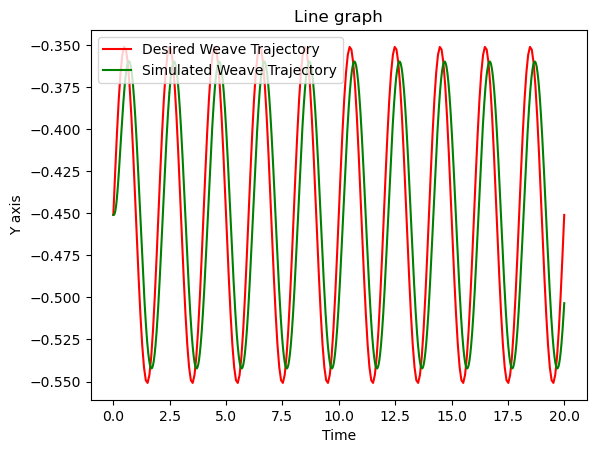

In [ ]:
weave_amp = 0.1
weave_ang_freq = np.pi

num_periods = 10

time_step_def = 1e-3

sim_time = (2*np.pi/weave_ang_freq)*num_periods
frames_per_sec = weave_ang_freq*4
t_lst = np.linspace(0, sim_time, int(sim_time*frames_per_sec))

rail_pos = 0.9

q_knot_output, iiwa_des_pos_world = create_q_knots(t_lst, weave_amp,weave_ang_freq, rail_pos)

q_knots = np.array(q_knot_output)

double_q_knots = np.hstack((q_knots, q_knots*0))

q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, double_q_knots[:, 0:18].T)

simulator, station_plant, sim_time_list, sim_iiwa_pos = BuildAndSimulateTrajectory(q_traj, q_knots[0], sim_time)
# plotting
plt.title("Line graph")
plt.xlabel("Time") 
plt.ylabel("Y axis") 

plt.plot(t_lst, iiwa_des_pos_world[:,1], color ="red", label="Desired Weave Trajectory")
plt.plot(sim_time_list, sim_iiwa_pos[:,1], color ="green", label="Simulated Weave Trajectory") 
plt.legend(loc="upper left")
plt.show()



In [ ]:
def calculate_amplitude_difference(desired_path, actual_path, desired_times, actual_times):

    return abs(min(actual_path)) / abs(min(desired_path))



In [ ]:
def simulate_weave(rail_pos, weave_ang_freq):
    meshcat.Delete("blue_bunny")
    meshcat.Delete("red_bunny")
    weave_amp = 0.1

    num_periods = 30

    time_step_def = 1e-3

    sim_time = (2*np.pi/weave_ang_freq)*num_periods
    frames_per_sec = weave_ang_freq*4
    t_lst = np.linspace(0, sim_time, int(sim_time*frames_per_sec))

    q_knot_output, iiwa_des_pos_world = create_q_knots(t_lst, weave_amp,weave_ang_freq, rail_pos)

    q_knots = np.array(q_knot_output)

    double_q_knots = np.hstack((q_knots, q_knots*0))

    q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, double_q_knots[:, 0:18].T)

    simulator, station_plant, sim_time_list, sim_iiwa_pos = BuildAndSimulateTrajectory(q_traj, q_knots[0], sim_time)
    

    
    
    # plotting
    plt.title("Graph for " + str(rail_pos))
    plt.xlabel("Time") 
    plt.ylabel("Y axis") 

    iiwa_des_y_centered = iiwa_des_pos_world[:,1] - iiwa_des_pos_world[0,1]
    iiwa_sim_y_centered = sim_iiwa_pos[:,1] - sim_iiwa_pos[0,1]

    plt.plot(t_lst, iiwa_des_y_centered, color ="red", label="Desired Weave Trajectory")
    plt.plot(sim_time_list, iiwa_sim_y_centered, color ="green", label="Simulated Weave Trajectory") 
    plt.legend(loc="upper left")
    plt.show()


    print("Ratio of simulated amplitude to desired amplitude: ")
    amplitude_ratio = calculate_amplitude_difference(iiwa_des_y_centered, iiwa_sim_y_centered, t_lst, sim_time_list)
    print(amplitude_ratio)
    return amplitude_ratio

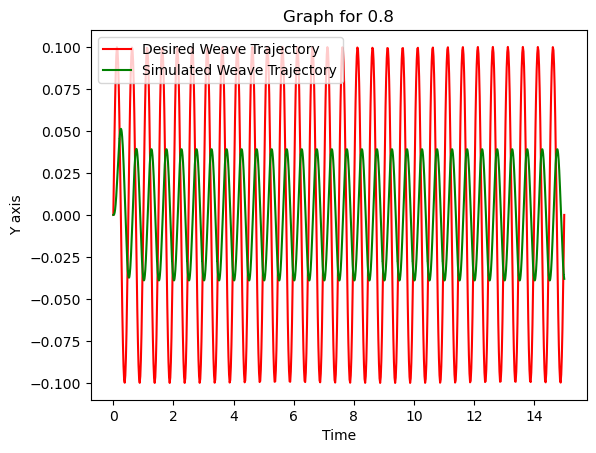

Ratio of simulated amplitude to desired amplitude: 
0.39005344083854393


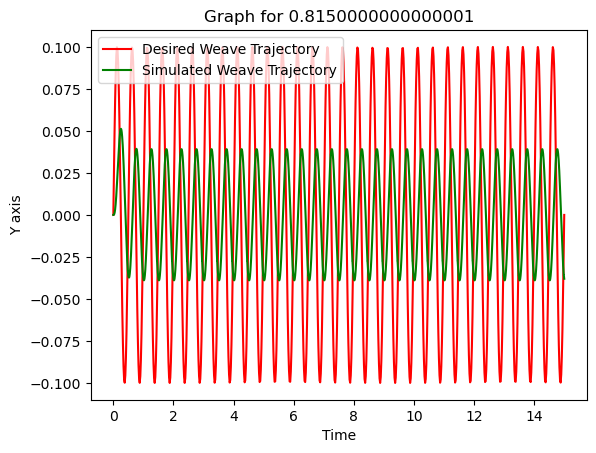

Ratio of simulated amplitude to desired amplitude: 
0.3895070989905004


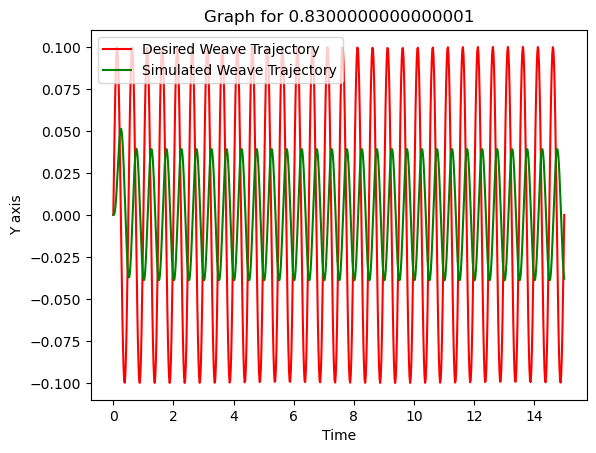

Ratio of simulated amplitude to desired amplitude: 
0.3890877604084318


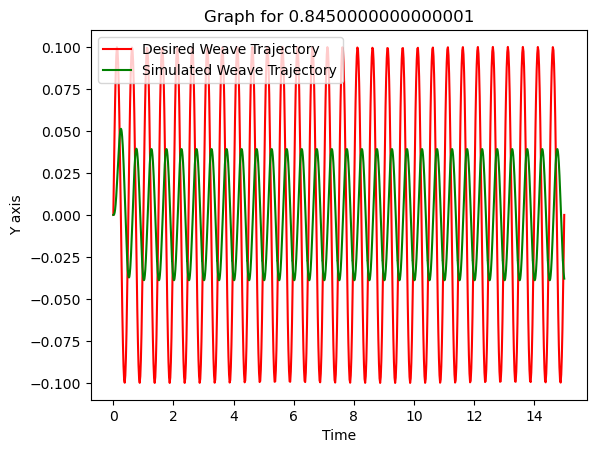

Ratio of simulated amplitude to desired amplitude: 
0.388768344386669


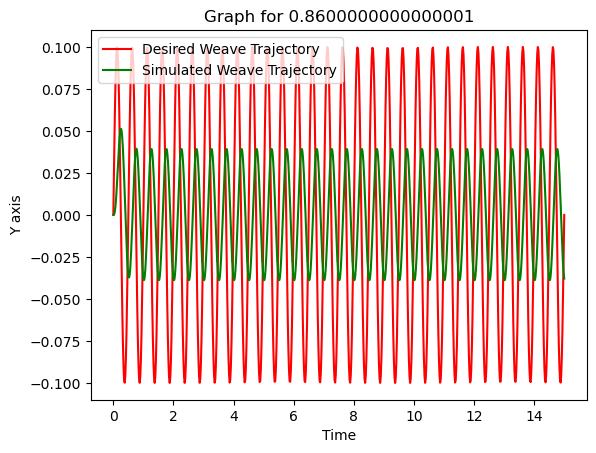

Ratio of simulated amplitude to desired amplitude: 
0.3885311459637999


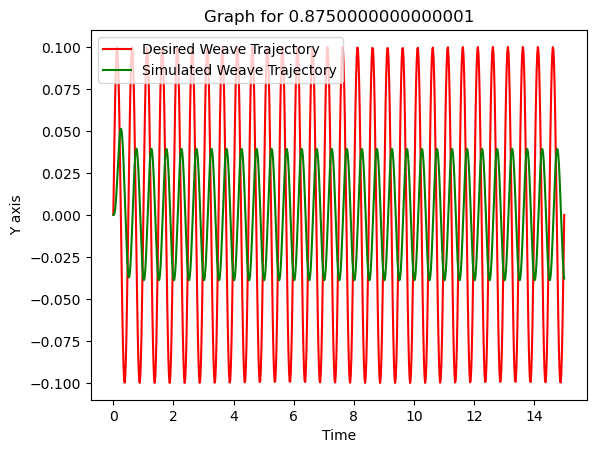

Ratio of simulated amplitude to desired amplitude: 
0.38836439721875704


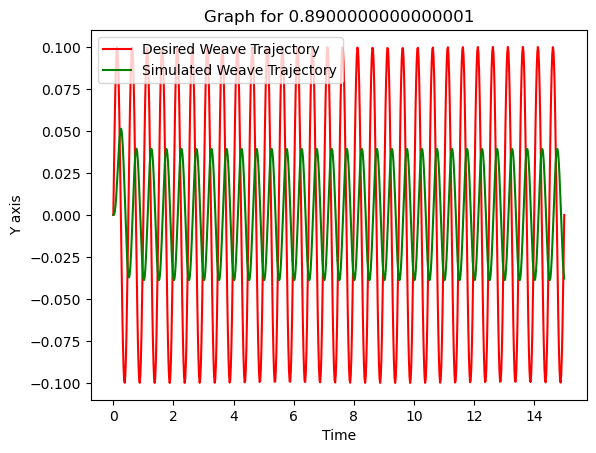

Ratio of simulated amplitude to desired amplitude: 
0.3882600814994518


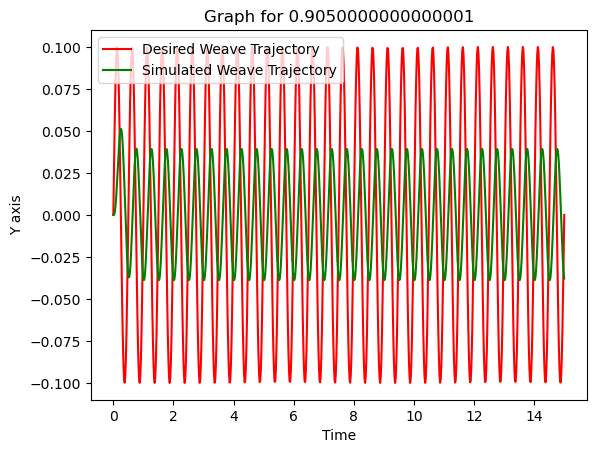

Ratio of simulated amplitude to desired amplitude: 
0.3882128434749013


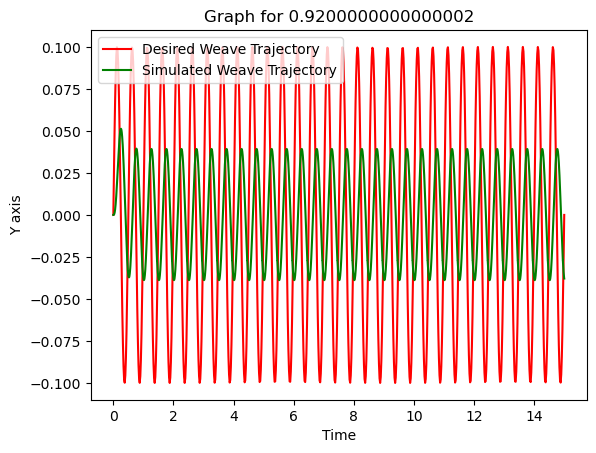

Ratio of simulated amplitude to desired amplitude: 
0.3882190653402481


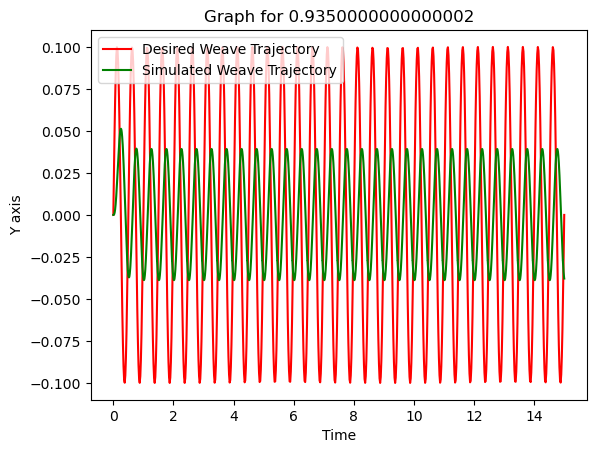

Ratio of simulated amplitude to desired amplitude: 
0.388276404956617
[0.8   0.815 0.83  0.845 0.86  0.875 0.89  0.905 0.92  0.935]
[0.39005344083854393, 0.3895070989905004, 0.3890877604084318, 0.388768344386669, 0.3885311459637999, 0.38836439721875704, 0.3882600814994518, 0.3882128434749013, 0.3882190653402481, 0.388276404956617]


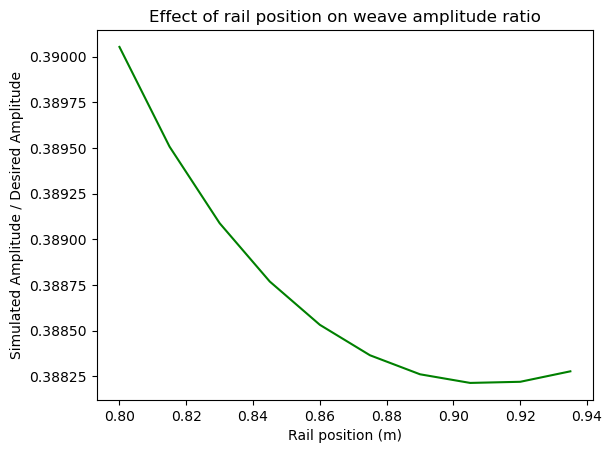

In [ ]:
#for i in range(5,10):
    #simulate_weave(0.8, 2*np.pi*i)

rail_pos_vals = np.arange(0.8,0.95,0.015)
amplitude_list = []


for rail_pos_val in rail_pos_vals:
    try:
        this_amplitude = simulate_weave(rail_pos_val, 2*np.pi*2)
        amplitude_list.append(this_amplitude)
    except:
        print("ope " + str(rail_pos_val))


# plotting
plt.title("Effect of rail position on weave amplitude ratio")
plt.xlabel("Rail position (m)") 
plt.ylabel("Simulated Amplitude / Desired Amplitude") 

print(rail_pos_vals)
print(amplitude_list)

plt.plot(rail_pos_vals, amplitude_list, color ="green") 
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7e656c9a-e35c-4740-b249-07fef330708d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>